<a href="https://colab.research.google.com/github/CeNCOOS/shoreERDDAP/blob/master/CeNCOOS_erddap_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a special version of a [Jupyter notebook](http://jupyter.org). If you don't know what that is or how to run one, that is OK. You can run it in this browser without downloading anything.

To run in Google Colab:

Go to **Runtime** (in the menu above)

Select the **Run All** command

If a box pops-up, **uncheck Reset all runtimes before running**

You will need to log into your google account.

Select the **Run All** command again


The code might take a little while to run in Google Colab the first time, since it has to download a couple of special python packages and some data to the server that is running the program.
If you have questions or comments, reach out to us at cencoos_staff@mbari.org.

In [39]:
# This stuff is all boilerplate for downloading important packages
# It might take a little while the first time it runs, because its downloading a couple of large packages
!apt-get -qq install python-cartopy python3-cartopy
!pip install erddapy
!pip install xarray
!pip install netcdf4
!pip install cmocean
from cartopy import crs as ccrs
from cartopy import feature as cfeature
from erddapy import ERDDAP
import datetime as dt
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cmocean.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

## We are going to access data from four different sources ##
- The moss landing marine labs seawater intake shore station
- The animal telemetry tracks from the Animal Telemetry Network
- Model output from the C-harm model for predicting harmful algal blooms
- Surface current data from High Frequency Radar in San Francisco Bay


First, lets define a helper function for creating a map. This will save a lot of time and space down the line. [Thanks Filipe](https://github.com/ocefpaf/2018-10-25-DMAC-TechWebinar/tree/master/notebooks)

In [0]:
# Mapping helper function

def make_map(projection=ccrs.PlateCarree(),extent=(-130.5,-116.75,31,42)):
    fig, ax = plt.subplots(
        subplot_kw={'projection': projection},
        figsize=(9, 12)
    )
    ax.background_patch.set_facecolor(cfeature.COLORS['water'])
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=True,)
    gl.xlines = False
    gl.ylines = False
    ax.coastlines('10m', zorder=20)
    coast_10m = cfeature.NaturalEarthFeature(category='physical', name='coastline',
                                             scale='10m', facecolor=cfeature.COLORS['land'])
    ax.add_feature(coast_10m, zorder=20)
    return fig, ax

First get the MLML seawater intake.

We need to find the ERDDAP page. This can be done by finding the site in the CeNCOOS Data Portal and clicking on the link to the ERDDAP server or by searching in at http://erddap.cencoos.org


![Find the Erddap page](https://media.giphy.com/media/pyEIJvbrOkgpbC2pUu/giphy.gif)

We want two peices of information from the ERDDAP server:

  1. The server name (erddap.cencoos.org)
  2. The dataset id (mlml_mlml_sea)
  ![Id](https://www.cencoos.org/sites/default/files/python_tutorials/erddap_access/erddap_dataset_id.png)

In [0]:
# Create ERDDAP object for requests
e = ERDDAP(
    server='https://erddap.cencoos.org/erddap/',
    protocol='tabledap', # Tabledap is the protocol used for non-gridded datasets, like a shore station
)
# This is the id
dataset_id = "mlml_mlml_sea"

# These are the variable that we are intersted in requestions
variables = [
  'time',
  'sea_water_temperature ',
  'fluorescence',
  'mass_concentration_of_oxygen_in_sea_water'
]

# We are only intersted in looking at the past 21 days. This can be done by creating
# a datetime object for the current time and substracting 21 days from it using a
# timedelta object. These objects can handle most of the tricky stuff about working
# with dates and times.

e.dataset_id = dataset_id
e.variables = variables
e.constraints = {
'time>=': (dt.datetime.today() - dt.timedelta(days=21)).isoformat(),
}

# Now lets use one of the methods of the erddap object to create a pandas dataframe
# out of the data, where it can be easily manipluated for analysis or visualization
df = e.to_pandas(
    index_col='time (UTC)',
    parse_dates=True,
).dropna()

In [26]:
# Lets look at the pandas dataframe
for var in df.columns:
  print(var)

sea_water_temperature (degree_Fahrenheit)
fluorescence (unknown)
mass_concentration_of_oxygen_in_sea_water (mg.L-1)


In [0]:
# lets make a new columns with temperature in degrees celsius
df['temp_c'] = (df['sea_water_temperature (degree_Fahrenheit)'] - 32)* 5/9

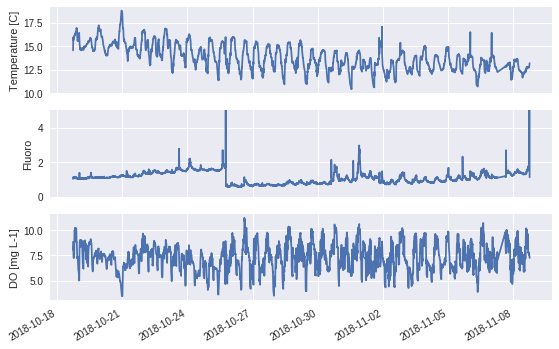

In [28]:
fig, (ax_temp, ax_flr, ax_oxy) = plt.subplots(3, sharex=True)
fig.set_size_inches(9,6)
ax_temp.plot(df['temp_c'])
ax_temp.set_ylabel('Temperature [C]')
ax_flr.plot(df['fluorescence (unknown)'])
ax_flr.set_ylim(0,5)
ax_flr.set_ylabel('Fluoro')
ax_oxy.plot(df['mass_concentration_of_oxygen_in_sea_water (mg.L-1)'])
ax_oxy.set_ylabel("DO [mg L-1]")
fig.autofmt_xdate()

## Now lets look through some of the ATN data

In [29]:
# Different ERDDAP server, but similar request to what we did before
e = ERDDAP(
    server='https://oceanview.pfeg.noaa.gov/erddap',
    protocol='tabledap',
)
e.dataset_id = "gtoppAT"

# We are going to restraint the dataset to the west coast
min_lon,max_lon,min_lat,max_lat= (-130,-116.75,32,42)

e.constraints = {
    'latitude>=': min_lat,
    'latitude<=': max_lat,
    'longitude>=': 360 + min_lon,
    'longitude<=': 360 + max_lon,
}

# We are only going to ask for animals postion, id, and common name
e.variables = [
 'time',
 'latitude',
 'longitude',
 'toppID',
 'commonName',
]

atn_df = e.to_pandas(
    parse_dates=True,
).dropna()
# This will print out all of the common names
[print(name) for name in atn_df['commonName'].unique()]
# Lets Plot it out now
atn_df['longitude (degrees_east)'] = -360+atn_df['longitude (degrees_east)']

Atlantic Sailfish
Black-footed Albatross
Blue Shark
Blue Whale
California Sea Lion
Common Thresher Shark
Fin Whale
Humboldt Squid
Humpback Whale
Juvenile White Shark
Laysan Albatross
Leatherback Sea Turtle
Northern Elephant Seal
Northern Fur Seal
Ocean Sunfish
Oceanic Whitetip Shark
Salmon Shark
Shortfin Mako Shark
Smooth Hammerhead
Sooty Shearwater
South American Sea Lion
Striped Marlin
Swordfish
White Shark


In [37]:
# Lets look at first couple of lines of the data
sunfish_df = atn_df[atn_df['commonName']=="Ocean Sunfish"]
sunfish_df.head()

,time (UTC),latitude (degrees_north),longitude (degrees_east),toppID,commonName
93060,2003-09-25T01:09:08Z,33.548,-118.11600,1303005,Ocean Sunfish
93061,2003-09-25T01:58:56Z,33.560,-118.10800,1303005,Ocean Sunfish
93062,2003-09-25T02:11:00Z,33.559,-118.09900,1303005,Ocean Sunfish
93063,2003-09-25T03:52:30Z,33.550,-118.09799,1303005,Ocean Sunfish
93064,2003-09-25T04:40:22Z,33.547,-118.10800,1303005,Ocean Sunfish


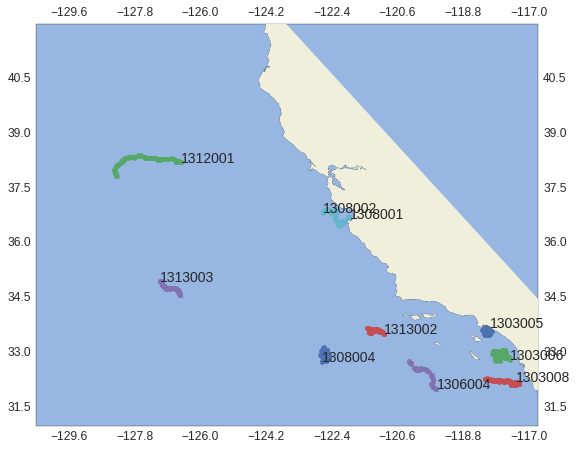

In [38]:
# Lets use the boilerplate make a map, the firstime this is run it will download some data about the coastline
fig, ax = make_map()
for ids in sunfish_df['toppID'].unique():
  if ids != 3209002: # We want to skip one deployment that was in Souther California
    single_track = sunfish_df[sunfish_df['toppID']==ids]
    ax.scatter(single_track['longitude (degrees_east)'],single_track['latitude (degrees_north)'],s=20)
    ax.text(single_track['longitude (degrees_east)'].iloc[-1],single_track['latitude (degrees_north)'].iloc[-1],ids,size=14,zorder=21)

# ax.set_ylim(33.5,38.5)
# ax.set_xlim(-125,-120.6)

## Now Lets access some HFR Surface currents

This will be using a different python package called xarray, which is great for retrieving and manipulating netCDF files.

The data is housed on a THREDDS server, so we will need to feed the URL to that dataset to make a request to lazy load the data, meaning we aren't going to access the data until we need it.

In [0]:
hfr_url = "http://hfrnet-tds.ucsd.edu/thredds/dodsC/HFR/USWC/2km/hourly/RTV/HFRADAR_US_West_Coast_2km_Resolution_Hourly_RTV_best.ncd"
hfr_ds = xr.open_dataset(hfr_url) # Lazy load the netcdf into an xarray dataset
recent_ds = hfr_ds.isel(time=-2) # grab the second most recent record 
u = recent_ds['u']
v = recent_ds['v']
speed = np.sqrt(u.values**2 + v.values**2) # Calculate magnitude (speed)
xx,yy = np.meshgrid(recent_ds['lon'], recent_ds['lat'])

Text(0.5,1.04,'2k HFR: 2018-11-08T14:00:00')

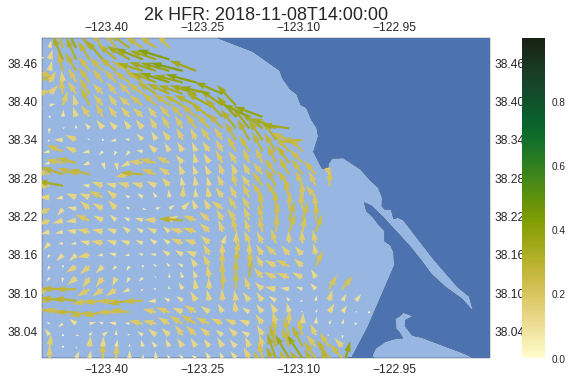

In [14]:
fig, ax = make_map()
ax.set_ylim(38,38.5)
ax.set_xlim(-123.5,-122.8)
Q = ax.quiver(xx, yy, u, v, speed, width=.005, scale_units="xy", scale=8, zorder=10, cmap=cm.speed)
divider = make_axes_locatable(ax)
ax_cb = divider.new_horizontal(size="5%", pad=.45, axes_class=plt.Axes)
fig.add_axes(ax_cb)
plt.colorbar(Q, cax=ax_cb)
ax.set_title("2k HFR: "+ str(recent_ds.time.values)[:-10],y=1.04,size=18)

## Lastly lets get the CA ROMS 3km dataset

In [0]:
roms_url = "http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_DAS.nc"
roms_ds = xr.open_dataset(roms_url)
nowcast_surface = roms_ds.isel(depth=0,time=-1) # grab the surface value, as well as the most recent nowcast

In [0]:
# Lets plot the temperature nowcast
nowcast_temp = nowcast_surface['temp']
xx_roms,yy_roms = np.meshgrid(nowcast_surface['lon'],nowcast_surface['lat'])

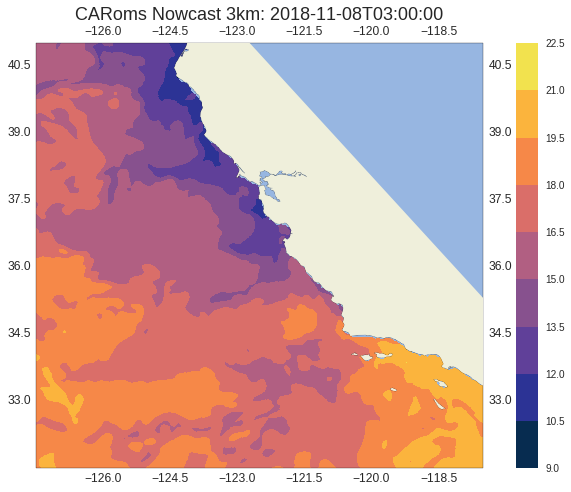

In [22]:
# Plot the data
fig, ax = make_map()
ax.set_ylim(31.5,41)
ax.set_xlim(-127.5,-117.5)
im = ax.contourf(xx_roms,yy_roms,nowcast_temp, cmap=cm.thermal)
ax.set_title("CARoms Nowcast 3km: "+ str(roms_ds.time.values[-1])[:-10],y=1.04,size=18)
divider = make_axes_locatable(ax)
ax_cb = divider.new_horizontal(size="5%", pad=0.45, axes_class=plt.Axes)
fig.add_axes(ax_cb)
plt.colorbar(im, cax=ax_cb)